In [1]:
import numpy as np
import math as mt
import cmath as cmt
from matplotlib import pylab as plt
from scipy.special import entr, xlogy  # Elementwise function for computing entropy

In [2]:
tmax  = 20
vtime = np.arange(0,tmax+1,1)

##   coin=0: KEMPE    coin=1: HADAMARD
coin = 1

In [3]:
# IC over the Bloch sphere
phiDeg  = (1-coin)*0 + coin*90   # Symmetric IC:  phiDeg=90(KEMPE)  phiDeg=90 (HADAMARD)
gamDeg  = 90

phiBloch = mt.radians(phiDeg)
gamBloch = mt.radians(gamDeg)

In [4]:
# Jensen-Shannon Dissimilarity
def jsd(px1, px2):

    ## convert to np.array
    px1, px2 = np.asarray(px1), np.asarray(px2)        
    
    ## Normalize vectors  to probabilities
    px1, px2 = px1/np.sum(px1), px2/np.sum(px2) 
    
    mixture = 0.5*(px1 + px2)

    entr_of_mean = np.sum( entr( mixture ) ) 
    mean_of_entr =  0.5*np.sum( entr( px1 ) )  +  0.5*np.sum( entr( px2 ) )
    
    output = entr_of_mean -  mean_of_entr
    
    return output/np.log(2)

def hellinger(px1, px2):
    ## convert to np.array
    px1, px2 = np.asarray(px1), np.asarray(px2)        
    
    ## Normalize vectors  to probabilities
    px1, px2 = px1/np.sum(px1), px2/np.sum(px2) 
    
    # Compute the H distance
    difer  = np.sqrt(px1) - np.sqrt(px2)
    sumdif = np.sum( (difer) ** 2 )
 
    return np.sqrt(sumdif)/np.sqrt(2) 

# Compute the components of An|0> + Bn|1>
def recursive_qw_dx_A_B():

  veci   = range(dx,npos-dx,1) 
  vecAA1 =  c11*vecA1[ veci - dx ] + c12*vecB1[ veci - dx ] 
  vecBB1 =  c21*vecA1[ veci + dx ] + c22*vecB1[ veci + dx ] 
 
  # Right/Left boundaries
  vecAA1 = np.concatenate( (np.zeros(dx),vecAA1,np.zeros(dx)), axis=None)
  vecBB1 = np.concatenate( (np.zeros(dx),vecBB1,np.zeros(dx)), axis=None)

  return vecAA1,vecBB1

def recursive_CW(): # classical walk
  veci  = np.arange(dx,npos-dx,1)
  vpCW2 = 0.5*vpCW[veci-dx] +  0.5*vpCW[veci+dx]
  vpCW3 = np.concatenate( (np.zeros(dx),vpCW2,np.zeros(dx)), axis=None)
  
  return vpCW3

In [5]:
# Now we set all sep lengtht with dx=1, but later we ca use different dx at each time
vdx   = np.asarray(  1*np.ones( len(vtime) ) , dtype=int)
sumdx = np.sum(vdx) 

xpos = np.arange(-int(sumdx)-1, int(sumdx)+2, 1) # [-L-2,...,L+2], to avoid Boundary issues we use plus/minus 2 
npos = len(xpos)
xc   = xpos.size//2      # central position = L   #Index Start at 0 #print(" xc:",xc,xpos[xc])    

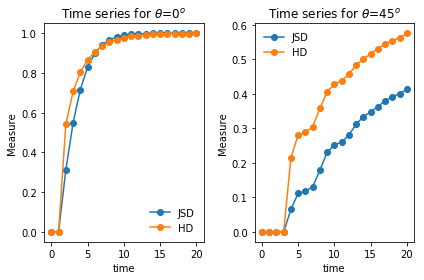

In [6]:
#plt.figure(figsize=(12,4))

#--------------------------------   dinamics: BEGIN    -------------------------------#
aux = 1
for thetDeg in [0,45]:    # Loop on the theta of the coin operator
    
    theta = mt.radians(thetDeg)     
    c11 = ( (1-coin)*(1 )  +  coin*( 1) ) * np.cos(theta)
    c12 = ( (1-coin)*(1j)  +  coin*( 1) ) * np.sin(theta)
    c21 = ( (1-coin)*(1j)  +  coin*( 1) ) * np.sin(theta)
    c22 = ( (1-coin)*(1 )  +  coin*(-1) ) * np.cos(theta)
    
    vecA1 = np.zeros(len(xpos), dtype=np.complex_)   
    vecB1 = np.zeros(len(xpos), dtype=np.complex_)    
    vpCW  = np.zeros(len(xpos), dtype=float      ) # for the Classical Walk

    vpCW[xc] = 1.0
  
    vecA1[xc]  = np.cos(gamBloch/2)                       
    vecB1[xc]  = np.sin(gamBloch/2) * np.exp(1j*phiBloch) 
    
    vpQW    = abs(vecA1)**2  +  abs(vecB1)**2 

    listSumP   = [ np.sum(vpQW) ]
    listJSD_QC = [ jsd(vpCW,vpQW)]
    listH_QC   = [ hellinger(vpCW,vpQW)]
    for t in np.arange(1,len(vtime),1):    
  
        # Quantum walk
        dx = vdx[t]    
        vecA1, vecB1 = recursive_qw_dx_A_B()
 
        # Computing coin components prob
        vpQW = abs(vecA1)**2 + abs(vecB1)**2
        listSumP.append(  np.sum(vpQW) ) 

        # Classical walk
        vpCW = recursive_CW()
        
        listJSD_QC.append( jsd(vpCW,vpQW) )
        listH_QC.append( hellinger(vpCW,vpQW) )

        
    vJSD = np.asarray(listJSD_QC)        
    vH = np.asarray(listH_QC)   
    
    plt.subplot(1, 2, aux)  #nrows, ncols, index
    plt.plot(vtime,vJSD,'o-',label='JSD' ) # JSD=Jensen-Shannon dissimilarity
    plt.plot(vtime,vH,'o-',label='HD') # HD = Hellinger distance 
    plt.title( r'Time series for $\theta$=%d$^o$ '%(thetDeg) )    
    plt.xlabel(r'time')
    plt.ylabel(r'Measure')
    plt.legend(loc='best', frameon=False)
    aux = aux + 1
    
plt.tight_layout()

In [7]:
# For an interesting application of the JSD in the context of QW 
# see the recent paper https://arxiv.org/abs/1907.12696 
# (Eqs.13-14 and Fig7)